# Internal diffusion

This notebook investigates how one can used Flow Matching to do image-2-image translation to solve a texture inpainting problem.

In [1]:
# Navigate to the root of the project and import necessary libraries
from hydra import initialize, compose
initialize(config_path="../confs", job_name="notebook")

import sys
import os
from PIL import Image
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath("../src"))
# We change the working directory to the root of the project
# Run this only once
root_path = Path.cwd().parent
os.chdir(root_path)
sys.path.append(root_path / "src")

/tmp/ipykernel_118527/1539113356.py:3: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path="../confs", job_name="notebook")


## Testing the dataset

In [ ]:
from internal_flow.data import get_datasets, SingleImageTestDataset, SingleImageTrainDataset
from src.internal_flow.utils import get_mask

image_path = Path('data/example_images/2.png')
mask_img = get_mask(image_path)

region_size = (256, 256)
seed = 42

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


Gtk-Message: 16:55:58.879: Not loading module "atk-bridge": The functionality is provided by GTK natively. Please try to not load it.
Gtk-Message: 16:55:58.958: Failed to load module "canberra-gtk-module"
Gtk-Message: 16:55:58.960: Failed to load module "canberra-gtk-module"


In [ ]:
mask_img.save('data/example_images/mask3.png')

In [3]:
%matplotlib inline

In [4]:
class TestOverride(SingleImageTestDataset):
    files = [""]

class TrainOverride(SingleImageTrainDataset):
    files = [""]

test_dataset = TestOverride(
    image_path=image_path,
    mask=Image.fromarray(np.array(mask_img)[..., 3]),
    seed=seed
)

In [5]:
train_dataset = TrainOverride(
    image_path=image_path,
    mask_box=test_dataset.region_box,
    seed=seed
)

batch = next(iter(train_dataset))


In [6]:
import torch
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=10,
    num_workers=0,
    pin_memory=True,
)

## Learn a Flow Model

In [7]:
from hydra.utils import instantiate
from omegaconf import OmegaConf
from src.flows.types import Predicts
os.environ["HYDRA_FULL_ERROR"] = "1"

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=30,
    num_workers=0,
    pin_memory=True,
)

cfg = compose(config_name="flow_model/internal")
flow_model = instantiate(cfg.flow_model)

trainer_cfg = compose(config_name="trainer/internal")
trainer = instantiate(trainer_cfg.trainer)

trainer.fit(flow_model, train_dataloaders=train_loader)

/home/mathis/anaconda3/lib/python3.12/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'flow_model/internal': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


Closing server running on port: 7860


/home/mathis/anaconda3/lib/python3.12/site-packages/pytorch_lightning/utilities/parsing.py:209: Attribute 'path' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['path'])`.
/home/mathis/anaconda3/lib/python3.12/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'trainer/internal': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
/home/mathis/anaconda3/lib/python3.12/site-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/mathis/anaconda3/lib/python3.12/site-packages/pytorch_li

/home/mathis/anaconda3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/mathis/Bureau/Stage - Code/StageTests/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | path  | AffinePath | 0      | train
1 | model | Model      | 165 K  | train
---------------------------------------------
165 K     Trainable params
0         Non-trainable params
165 K     Total params
0.661     Total estimated model params size (MB)
51        Modules in train mode
0         Modules in eval mode
/home/mathis/anaconda3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/mathis/anaconda3/lib/pytho

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

Error in callback <bound method _WandbInit._post_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x7f204e9f9e80>> (for post_run_cell), with arguments args (<ExecutionResult object at 7f21b408bd70, execution_count=7 error_before_exec=None error_in_exec=name 'exit' is not defined info=<ExecutionInfo object at 7f209269da90, raw_cell="from hydra.utils import instantiate
from omegaconf.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/home/mathis/Bureau/Stage%20-%20Code/StageTests/notebooks/internal_diffusion.ipynb#X12sZmlsZQ%3D%3D> result=None>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

In [ ]:
# Save the model
flow_model_path = Path("models/flow_model_2")
flow_model_path.mkdir(parents=True, exist_ok=True)
flow_model.save(flow_model_path / "flow_model.pt")

Error in callback <bound method _WandbInit._pre_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x7f204e9f9e80>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7f2027b67dd0, raw_cell="# Save the model
flow_model_path = Path("models/fl.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/home/mathis/Bureau/Stage%20-%20Code/StageTests/notebooks/internal_diffusion.ipynb#X20sZmlsZQ%3D%3D>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

AttributeError: 'Flow' object has no attribute 'save'

Error in callback <bound method _WandbInit._post_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x7f204e9f9e80>> (for post_run_cell), with arguments args (<ExecutionResult object at 7f2027bc37a0, execution_count=8 error_before_exec=None error_in_exec='Flow' object has no attribute 'save' info=<ExecutionInfo object at 7f2027b67dd0, raw_cell="# Save the model
flow_model_path = Path("models/fl.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/home/mathis/Bureau/Stage%20-%20Code/StageTests/notebooks/internal_diffusion.ipynb#X20sZmlsZQ%3D%3D> result=None>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

In [9]:
mean = np.array(Image.open(image_path)).mean(axis=(0, 1))
std = np.array(Image.open(image_path)).std(axis=(0, 1)) 

Error in callback <bound method _WandbInit._pre_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x7f204e9f9e80>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7f2026f5cdd0, raw_cell="mean = np.array(Image.open(image_path)).mean(axis=.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/home/mathis/Bureau/Stage%20-%20Code/StageTests/notebooks/internal_diffusion.ipynb#X13sZmlsZQ%3D%3D>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

Error in callback <bound method _WandbInit._post_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x7f204e9f9e80>> (for post_run_cell), with arguments args (<ExecutionResult object at 7f2026f10dd0, execution_count=9 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7f2026f5cdd0, raw_cell="mean = np.array(Image.open(image_path)).mean(axis=.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/home/mathis/Bureau/Stage%20-%20Code/StageTests/notebooks/internal_diffusion.ipynb#X13sZmlsZQ%3D%3D> result=None>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

Error in callback <bound method _WandbInit._pre_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x7f204e9f9e80>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7f2024d7ff80, raw_cell="train_loader = torch.utils.data.DataLoader(
    tr.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/home/mathis/Bureau/Stage%20-%20Code/StageTests/notebooks/internal_diffusion.ipynb#X14sZmlsZQ%3D%3D>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

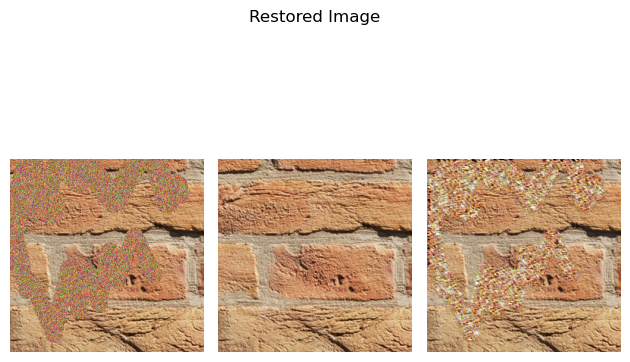

Error in callback <bound method _WandbInit._post_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x7f204e9f9e80>> (for post_run_cell), with arguments args (<ExecutionResult object at 7f2024d7db20, execution_count=11 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7f2024d7ff80, raw_cell="train_loader = torch.utils.data.DataLoader(
    tr.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/home/mathis/Bureau/Stage%20-%20Code/StageTests/notebooks/internal_diffusion.ipynb#X14sZmlsZQ%3D%3D> result=None>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

In [11]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=1,
    num_workers=0,
    pin_memory=True,
)

noisy, clean, mask = next(iter(train_loader))

def to_img(tensor):
    tensor = tensor.permute(0, 2, 3, 1).cpu().numpy()
    tensor = tensor * std + mean
    tensor = np.clip(tensor, 0, 255).astype(np.uint8)
    return tensor

flow_model = flow_model.to("cuda")
noisy = noisy.to("cuda")
mask = mask.to("cuda")

restored = flow_model(noisy, y=mask)
restored = to_img(restored)

noisy = to_img(noisy)
clean = to_img(clean)

plt.subplot(1, 3, 1)
plt.imshow(noisy[0])
plt.axis('off')
plt.suptitle("Noisy Image")
plt.subplot(1, 3, 2)
plt.imshow(clean[0])
plt.axis('off')
plt.suptitle("Clean Image")
plt.subplot(1, 3, 3)
plt.imshow(restored[0])
plt.axis('off')
plt.suptitle("Restored Image")
plt.tight_layout()
plt.show()

Error in callback <bound method _WandbInit._pre_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x7b0f85b074a0>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7b0f47697560, raw_cell="noisy, clean, mask = next(iter(train_loader))

def.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/home/mathis/Bureau/Stage%20-%20Code/StageTests/notebooks/internal_diffusion.ipynb#X16sZmlsZQ%3D%3D>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

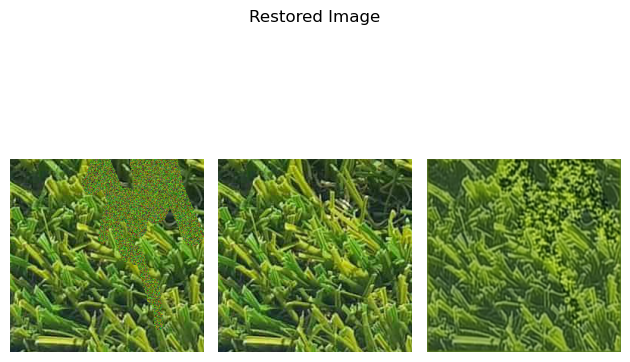

Error in callback <bound method _WandbInit._post_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x7b0f85b074a0>> (for post_run_cell), with arguments args (<ExecutionResult object at 7b0f47697f80, execution_count=10 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7b0f47697560, raw_cell="noisy, clean, mask = next(iter(train_loader))

def.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/home/mathis/Bureau/Stage%20-%20Code/StageTests/notebooks/internal_diffusion.ipynb#X16sZmlsZQ%3D%3D> result=None>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

In [ ]:
noisy, clean, mask = next(iter(train_loader))

def to_img(tensor):
    tensor = tensor.permute(0, 2, 3, 1).cpu().numpy()
    tensor = tensor * std + mean
    tensor = np.clip(tensor, 0, 255).astype(np.uint8)
    return tensor

flow_model = flow_model.to("cuda")
noisy = noisy.to("cuda")
mask = mask.to("cuda")

restored = flow_model(noisy, y=mask)
restored = to_img(restored)

noisy = to_img(noisy)
clean = to_img(clean)

plt.subplot(1, 3, 1)
plt.imshow(noisy[0])
plt.axis('off')
plt.suptitle("Noisy Image")
plt.subplot(1, 3, 2)
plt.imshow(clean[0])
plt.axis('off')
plt.suptitle("Clean Image")
plt.subplot(1, 3, 3)
plt.imshow(restored[0])
plt.axis('off')
plt.suptitle("Restored Image")
plt.tight_layout()
plt.show()

In [ ]:
%matplotlib tk